In [1]:
pip install /Users/qingchuanlyu/Documents/Conferences/ICML-2025/icml2025/code/mlrose

Processing ./mlrose
  Preparing metadata (setup.py) ... done
  Created wheel for mlrose_hiive: filename=mlrose_hiive-2.2.4-py3-none-any.whl size=130539 sha256=805551508b96bb85a28fb8681201420ad29dc6d0512dece75f81687ad895646a
  Stored in directory: /private/var/folders/c6/5zg6wy5n121f2pzclkwbzplm0000gn/T/pip-ephem-wheel-cache-82rkojdk/wheels/77/c5/de/7a63a2c78a12ad335a5091a9209439e12d86616744464a5ae4
Successfully built mlrose_hiive
  Attempting uninstall: mlrose_hiive
    Found existing installation: mlrose_hiive 2.2.4
    Uninstalling mlrose_hiive-2.2.4:
      Successfully uninstalled mlrose_hiive-2.2.4
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mlrose_hiive as mh

In [3]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

from IPython.core.display import display, HTML # for some notebook formatting.

import logging
import networkx as nx
import matplotlib.pyplot as plt
import string


from ast import literal_eval

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score

# switch off the chatter
logging.basicConfig(level=logging.WARNING)

In [4]:
import pandas as pd

In [5]:
# # Flip Flop
problem_ffp = mh.FlipFlopGenerator().generate(seed=0, size=1000)
#state = problem_ffp.get_state()

In [6]:
# GABF runner class
# 1. tune population size and mutation rates
ga_ffp = mh.GABFRunner(problem=problem_ffp,
              experiment_name='ffp_ga',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=0,
              iteration_list=2 ** np.arange(12),
              max_attempts=500,
              population_sizes=[20, 50, 100, 150],
              mutation_rates=[0.1, 0.08]) # Probability of a mutation at each element of the state vector during reproduction, expressed as a value between 0 and 1.

# the two data frames will contain the results
df_run_stats_ffp, df_run_curves_ffp = ga_ffp.run()

In [7]:
df_run_curves_ffp.shape

(11307, 7)

In [8]:
df_run_curves_ffp.head()

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
0,0,0.014619,516.0,0.0,20,0.1,2048
1,1,0.058546,540.0,2.0,20,0.1,2048
2,2,0.094761,544.0,4.0,20,0.1,2048
3,3,0.110585,548.0,6.0,20,0.1,2048
4,4,0.115006,548.0,7.0,20,0.1,2048


In [9]:
df_run_curves_ffp['Fitness'].max()

999.0

In [10]:
# need to check Time and FEvals

In [11]:
df_run_curves_ffp.dtypes

Iteration            int64
Time               float64
Fitness            float64
FEvals             float64
Population Size      int64
Mutation Rate      float64
max_iters            int64
dtype: object

In [12]:
df_curves_bestfitness_ffp = df_run_curves_ffp[(df_run_curves_ffp['Fitness'] == df_run_curves_ffp['Fitness'].max())]

In [13]:
df_curves_bestfitness_ffp

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
5601,1503,8.929482,999.0,1826.0,50,0.10,2048
7016,1414,8.462206,999.0,1758.0,50,0.08,2048
8303,1286,7.809637,999.0,1581.0,100,0.10,2048
9437,1133,6.967758,999.0,1429.0,100,0.08,2048
10342,904,5.832928,999.0,1184.0,150,0.10,2048
11306,963,6.130934,999.0,1245.0,150,0.08,2048


In [14]:
df_curves_bestfitness_ffp.groupby(['Population Size', 'Mutation Rate']).agg({'FEvals': 'min', 'Iteration': 'mean', 'Time': 'min'}).reset_index()
# Temp = 1 => less Fevals. Pick temp=1

,Population Size,Mutation Rate,FEvals,Iteration,Time
0,50,0.08,1758.0,1414.0,8.462206
1,50,0.10,1826.0,1503.0,8.929482
2,100,0.08,1429.0,1133.0,6.967758
3,100,0.10,1581.0,1286.0,7.809637
4,150,0.08,1245.0,963.0,6.130934
5,150,0.10,1184.0,904.0,5.832928


In [52]:
# pick pop size = 150 and mutation_rate = 0.1, with smallest FEvals, iterations and time

In [15]:
df_run_curves_ffp.head()

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
0,0,0.014619,516.0,0.0,20,0.1,2048
1,1,0.058546,540.0,2.0,20,0.1,2048
2,2,0.094761,544.0,4.0,20,0.1,2048
3,3,0.110585,548.0,6.0,20,0.1,2048
4,4,0.115006,548.0,7.0,20,0.1,2048


In [17]:
# clean up an existing result table to store the iterative resutls
df_iter_curves_ffp = df_run_curves_ffp.drop(df_run_curves_ffp.index, inplace=False)

In [19]:
# GABF runner
# 2. iterate through 10 seeds
for s in range(10):
    ga_ffp = mh.GABFRunner(problem=problem_ffp,
              experiment_name='ffp_ga_{s}',
              output_directory=None, # note: specify an output directory to have results saved to disk
              seed=s,
              iteration_list=2 ** np.arange(12),
              max_attempts=500,
              population_sizes=[150], # 20 bits in total
              mutation_rates=[0.1])

    # the two data frames will contain the results
    df_run_stats_ffp_sub, df_run_curves_ffp_sub = ga_ffp.run()
    # append to the result df
    #df_iter_curves_ffp = df_iter_curves_ffp.append(df_run_curves_ffp_sub)
    df_iter_curves_ffp = pd.concat([df_iter_curves_ffp, df_run_curves_ffp_sub])

In [20]:
df_iter_curves_ffp.to_csv('df_iter_curves_ffp_gabf_1000.csv', index=False)

In [21]:
df_iter_curves_ffp.shape

(9168, 7)

In [22]:
df_iter_curves_ffp.head()

,Iteration,Time,Fitness,FEvals,Population Size,Mutation Rate,max_iters
0,0,0.015125,516.0,0.0,150,0.1,2048
1,1,0.086474,546.0,2.0,150,0.1,2048
2,2,0.169273,546.0,3.0,150,0.1,2048
3,3,0.301828,546.0,4.0,150,0.1,2048
4,4,0.353134,549.0,6.0,150,0.1,2048


In [23]:
df_iter_curves_ffp.Iteration.max()

988

In [24]:
df_fitness_iter_ffp = df_iter_curves_ffp.groupby('Iteration')\
                                .agg(avg_fitness=('Fitness', 'mean'), var_fitness = ('Fitness', 'var'))\
                                .reset_index()

In [25]:
df_fitness_iter_ffp.shape

(989, 3)

In [26]:
df_fitness_iter_ffp.head()

,Iteration,avg_fitness,var_fitness
0,0,496.0,233.777778
1,1,544.8,85.955556
2,2,547.1,53.877778
3,3,550.4,48.266667
4,4,551.2,39.511111


In [27]:
df_iter_curves_ffp.Fitness.max()

999.0

In [28]:
# convergence point
df_iter_curves_ffp[df_iter_curves_ffp.Fitness == df_iter_curves_ffp.Fitness.max()].Iteration

904    904
875    875
868    868
958    958
898    898
920    920
988    988
915    915
933    933
899    899
Name: Iteration, dtype: int64

In [29]:
# converge point
df_fitness_iter_ffp[df_fitness_iter_ffp.avg_fitness >= df_iter_curves_ffp.Fitness.max()].Iteration.min()

988

In [30]:
df_fitness_iter_ffp.avg_fitness.max()

999.0

In [31]:
df_fitness_iter_ffp['stddev_fitness'] = df_fitness_iter_ffp['var_fitness'].apply(np.sqrt)

In [32]:
df_fitness_iter_ffp['stddev_fitness'].max()

15.289793254906288

In [33]:
df_fitness_iter_ffp.head()

,Iteration,avg_fitness,var_fitness,stddev_fitness
0,0,496.0,233.777778,15.289793
1,1,544.8,85.955556,9.271222
2,2,547.1,53.877778,7.340148
3,3,550.4,48.266667,6.947422
4,4,551.2,39.511111,6.285786


Text(0, 0.5, 'Fitness')

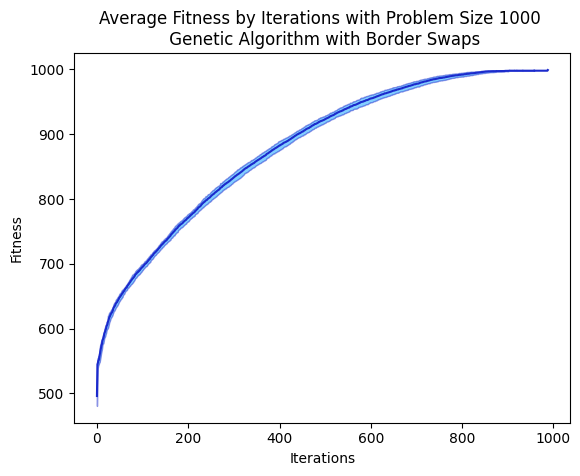

In [34]:
plt.plot(df_fitness_iter_ffp.Iteration, df_fitness_iter_ffp.avg_fitness, 'k', color='#1B2ACC')
plt.fill_between(df_fitness_iter_ffp.Iteration, df_fitness_iter_ffp.avg_fitness - df_fitness_iter_ffp.stddev_fitness\
                 , df_fitness_iter_ffp.avg_fitness + df_fitness_iter_ffp.stddev_fitness\
                 , alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.title('Average Fitness by Iterations with Problem Size 1000 \n Genetic Algorithm with Border Swaps')
plt.xlabel('Iterations')
plt.ylabel('Fitness')

In [35]:
# Fevals - iteration

In [36]:
df_FEvals_iter_ffp = df_iter_curves_ffp.groupby('Iteration')\
                                .agg(avg_FEvals=('FEvals', 'mean'), var_FEvals = ('FEvals', 'var'))\
                                .reset_index()

In [37]:
df_FEvals_iter_ffp.shape

(989, 3)

In [38]:
df_FEvals_iter_ffp.head()

,Iteration,avg_FEvals,var_FEvals
0,0,0.0,0.000000
1,1,2.0,0.000000
2,2,3.5,0.277778
3,3,5.1,0.766667
4,4,6.4,1.155556


In [39]:
df_FEvals_iter_ffp['stddev_FEvals'] = df_FEvals_iter_ffp['var_FEvals'].apply(np.sqrt)

In [40]:
df_FEvals_iter_ffp['stddev_FEvals'].min(), df_FEvals_iter_ffp['stddev_FEvals'].max()

(0.0, 10.692676621563601)

In [41]:
df_FEvals_iter_ffp.head()

,Iteration,avg_FEvals,var_FEvals,stddev_FEvals
0,0,0.0,0.000000,0.000000
1,1,2.0,0.000000,0.000000
2,2,3.5,0.277778,0.527046
3,3,5.1,0.766667,0.875595
4,4,6.4,1.155556,1.074968


In [42]:
df_FEvals_iter_ffp[df_FEvals_iter_ffp['Iteration']==988].avg_FEvals

988    1292.0
Name: avg_FEvals, dtype: float64

In [43]:
df_FEvals_iter_ffp.to_csv('df_FEvals_iter_1000_gabf981.csv')

Text(0, 0.5, 'FEvals')

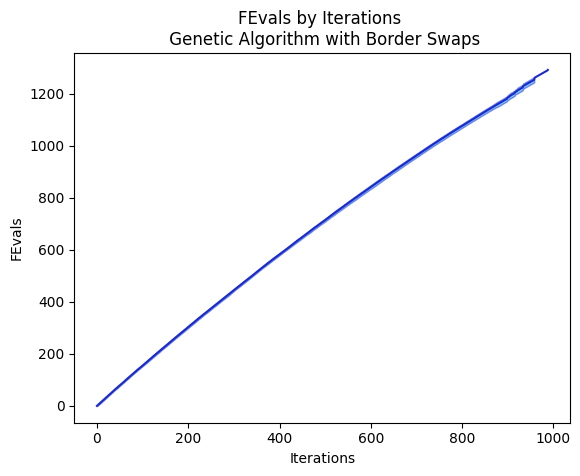

In [44]:
plt.plot(df_FEvals_iter_ffp.Iteration, df_FEvals_iter_ffp.avg_FEvals, 'k', color='#1B2ACC')
plt.fill_between(df_FEvals_iter_ffp.Iteration, df_FEvals_iter_ffp.avg_FEvals - df_FEvals_iter_ffp.stddev_FEvals\
                 , df_FEvals_iter_ffp.avg_FEvals + df_FEvals_iter_ffp.stddev_FEvals\
                 , alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.title('FEvals by Iterations \n Genetic Algorithm with Border Swaps')
plt.xlabel('Iterations')
plt.ylabel('FEvals')

In [45]:
# fitness - wall clock time

In [46]:
df_time_iter_ffp = df_iter_curves_ffp.groupby('Iteration')\
                                .agg(avg_time=('Time', 'mean'), var_time = ('Time', 'var'))\
                                .reset_index()

In [47]:
df_time_iter_ffp.shape

(989, 3)

In [48]:
df_time_iter_ffp.head()

,Iteration,avg_time,var_time
0,0,0.006623,0.000009
1,1,0.043916,0.000226
2,2,0.085846,0.000866
3,3,0.136359,0.003538
4,4,0.167911,0.004435


In [49]:
df_time_iter_ffp['stddev_time'] = df_time_iter_ffp['var_time'].apply(np.sqrt)

In [50]:
df_time_iter_ffp.head()

,Iteration,avg_time,var_time,stddev_time
0,0,0.006623,0.000009,0.003036
1,1,0.043916,0.000226,0.015030
2,2,0.085846,0.000866,0.029432
3,3,0.136359,0.003538,0.059481
4,4,0.167911,0.004435,0.066594


In [51]:
df_time_iter_ffp.stddev_time.max()

5.049018474103493

Text(0, 0.5, 'Time')

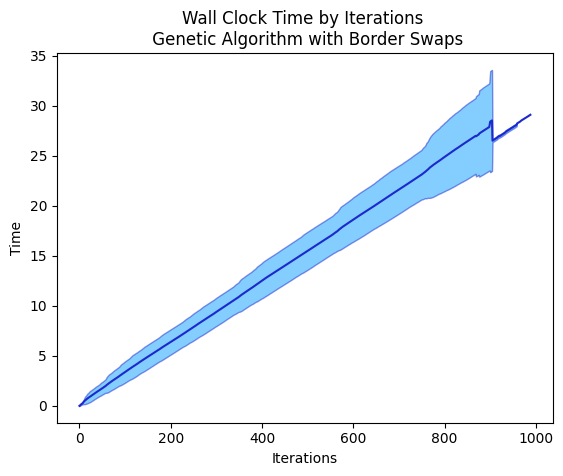

In [52]:
plt.plot(df_time_iter_ffp.Iteration, df_time_iter_ffp.avg_time, 'k', color='#1B2ACC')
plt.fill_between(df_time_iter_ffp.Iteration, df_time_iter_ffp.avg_time - df_time_iter_ffp.stddev_time\
                 , df_time_iter_ffp.avg_time + df_time_iter_ffp.stddev_time\
                 , alpha=0.5, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.title('Wall Clock Time by Iterations \n Genetic Algorithm with Border Swaps')
plt.xlabel('Iterations')
plt.ylabel('Time')

In [53]:
df_time_iter_ffp[df_time_iter_ffp.stddev_time==df_time_iter_ffp.stddev_time.max()].Iteration

900    900
Name: Iteration, dtype: int64

In [54]:
df_time_iter_ffp.avg_time.max()

29.10980809602188

In [55]:
df_time_iter_ffp.stddev_time.max()

5.049018474103493

In [56]:
df_time_iter_ffp.to_csv('df_time_iter_1000_gabf981.csv')